In [1]:
# Not critical that it gets scaled (Whitney's was easiest, scale from the start with all data)

In [1]:
# Take a time series
# Build a pure time series model (if I look @ the period ahead, what's the potential outcome)
# Independent measurement is the time series & (X and y are the same) 
# Target variable is the closing price
# How do I move my predictions into the future, instead of the past? (Can't change X, can't send future values into X, meaning we'll choose y)
# Estimate model by giving it a window into the future for y.
# Train it to look into the future
# Draw out the flowchart.

In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
# News source is from Yahoo Finance


In [3]:
import yfinance as yf
amd = yf.Ticker("AMD")
amd_hist = amd.history(period="max")

amd.info # Stored in a dictionary with all kinds of info on the company

{'zip': '95054',
 'sector': 'Technology',
 'fullTimeEmployees': 12600,
 'longBusinessSummary': 'Advanced Micro Devices, Inc. operates as a semiconductor company worldwide. The company operates in two segments, Computing and Graphics; and Enterprise, Embedded and Semi-Custom. Its products include x86 microprocessors as an accelerated processing unit, chipsets, discrete and integrated graphics processing units (GPUs), data center and professional GPUs, and development services; and server and embedded processors, and semi-custom System-on-Chip (SoC) products, development services, and technology for game consoles. The company provides x86 microprocessors for desktop PCs under the AMD Ryzen, AMD Ryzen PRO, Ryzen, Threadripper, AMD A-Series, AMD FX, AMD Athlon, AMD Athlon PRO, and AMD Pro A-Series processors brands; microprocessors for notebook and 2-in-1s under the AMD Ryzen, AMD A-Series, AMD Athlon, AMD Ryzen PRO, AMD Athlon PRO, and AMD Pro A-Series processors brands; microprocessors f

In [4]:
# amd_hist
amd_hist = amd_hist.resample("1M").mean() # Monthly mean while 'open', 'volume', 'dividends', etc... are in the df 
# Next drop all columns except the Close & store it
amd_hist # Monthly close prices here

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-03-31,0.000000,2.855114,2.712121,2.756629,4.825091e+05,0.0,0.0
1980-04-30,0.000000,2.650298,2.528770,2.586310,4.128000e+05,0.0,0.0
1980-05-31,0.000000,2.794643,2.709325,2.764385,3.190857e+05,0.0,0.0
1980-06-30,0.000000,3.061012,2.984623,3.016865,2.572571e+05,0.0,0.0
1980-07-31,0.000000,3.618371,3.504735,3.569602,4.370727e+05,0.0,0.0
...,...,...,...,...,...,...,...
2021-04-30,82.146666,83.303809,80.679047,81.844286,4.696542e+07,0.0,0.0
2021-05-31,76.905500,77.995999,75.833001,76.976000,4.464606e+07,0.0,0.0
2021-06-30,82.932272,84.287273,82.162728,83.331363,3.691171e+07,0.0,0.0


In [5]:
# Make the csv file with closing prices & date
amd_df = amd_hist.Close.to_frame()
amd_Prototype_file = amd_df.to_csv(r'C:\Users\Yonathan\Desktop\amd_prototype.csv', index=True)

In [6]:
type(amd_df.index[0]) # Won't allow Date or date to be called for some reason. 
# amd_df["2017-01-01":'2021-07-31'] example code here to ask for a certain part of the available data within the df
amd_df["2017-01-01":'2021-07-31'].Close.to_frame() # example code here to ask for the close as well within desired time

# Example for a monthly close
amd_df['2019-06'].mean() # Warning of future removal appears so alternative to this would be df.loc['2019-06']

<ipython-input-6-3cf9ed7f9652>:6: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  amd_df['2019-06'].mean() # Warning of future removal appears so alternative to this would be df.loc['2019-06']


Close    30.443
dtype: float64

In [21]:
pd.DatetimeIndex(amd_df)

/Users/manu/opt/anaconda3/lib/python3.8/site-packages/pandas/io/formats/printing.py:387: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  head = [formatter(x) for x in obj[:n]]
/Users/manu/opt/anaconda3/lib/python3.8/site-packages/pandas/io/formats/printing.py:388: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  tail = [formatter(x) for x in obj[-n:]]


DatetimeIndex(['['1970-01-01T00:00:00.000000002']',
               '['1970-01-01T00:00:00.000000002']',
               '['1970-01-01T00:00:00.000000002']',
               '['1970-01-01T00:00:00.000000003']',
               '['1970-01-01T00:00:00.000000003']',
               '['1970-01-01T00:00:00.000000004']',
               '['1970-01-01T00:00:00.000000004']',
               '['1970-01-01T00:00:00.000000005']',
               '['1970-01-01T00:00:00.000000006']',
               '['1970-01-01T00:00:00.000000005']',
               ...
               '['1970-01-01T00:00:00.000000083']',
               '['1970-01-01T00:00:00.000000093']',
               '['1970-01-01T00:00:00.000000091']',
               '['1970-01-01T00:00:00.000000088']',
               '['1970-01-01T00:00:00.000000079']',
               '['1970-01-01T00:00:00.000000081']',
               '['1970-01-01T00:00:00.000000076']',
               '['1970-01-01T00:00:00.000000083']',
               '['1970-01-01T00:00:00.0000000

In [22]:
amd_df

,Close
Date,
1980-03-31,2.756629
1980-04-30,2.586310
1980-05-31,2.764385
1980-06-30,3.016865
1980-07-31,3.569602
...,...
2021-04-30,81.844286
2021-05-31,76.976000
2021-06-30,83.331363


In [7]:
amd_df.Close.to_frame()

,Close
Date,
1980-03-31,2.756629
1980-04-30,2.586310
1980-05-31,2.764385
1980-06-30,3.016865
1980-07-31,3.569602
...,...
2021-04-30,81.844286
2021-05-31,76.976000
2021-06-30,83.331363


In [8]:
amd_Quart_financials = amd.quarterly_financials

In [9]:
amd.cashflow

,2020-12-26,2019-12-28,2018-12-29,2017-12-30
Investments,-6.580000e+08,41000000.0,-78000000.0,-78000000.0
Change To Liabilities,-5.130000e+08,153000000.0,212000000.0,-8000000.0
Total Cashflows From Investing Activities,-9.520000e+08,-149000000.0,-170000000.0,-54000000.0
Total Cash From Financing Activities,6.000000e+06,43000000.0,28000000.0,-33000000.0
Change To Operating Activities,2.180000e+08,65000000.0,18000000.0,-130000000.0
Issuance Of Stock,8.500000e+07,523000000.0,70000000.0,20000000.0
Net Income,2.490000e+09,341000000.0,337000000.0,-33000000.0
Change In Cash,1.250000e+08,387000000.0,-108000000.0,-75000000.0
Repurchase Of Stock,-7.800000e+07,-6000000.0,-6000000.0,-6000000.0
Total Cash From Operating Activities,1.071000e+09,493000000.0,34000000.0,12000000.0


In [10]:
amd_recommendations = amd.recommendations['To Grade'].value_counts() # Try to group it by year or month
# Not correct: amd_recommendations = amd_recommendations.resample("1M").mean()
#amd_recommendations

In [11]:
amd.recommendations['To Grade'].value_counts()

Buy               68
Neutral           53
Outperform        33
Hold              21
Equal-Weight      14
Underperform      11
Market Perform    10
Overweight         8
Underweight        8
Sell               6
Positive           3
                   1
Perform            1
Sector Weight      1
Negative           1
Sector Perform     1
Name: To Grade, dtype: int64

In [12]:
amd.calendar

,0,1
Earnings Date,2021-10-25 00:00:00,2021-10-29 00:00:00
Earnings Average,0.54,0.54
Earnings Low,0.46,0.46
Earnings High,0.6,0.6
Revenue Average,3617850000,3617850000
Revenue Low,3500000000,3500000000
Revenue High,3828000000,3828000000


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

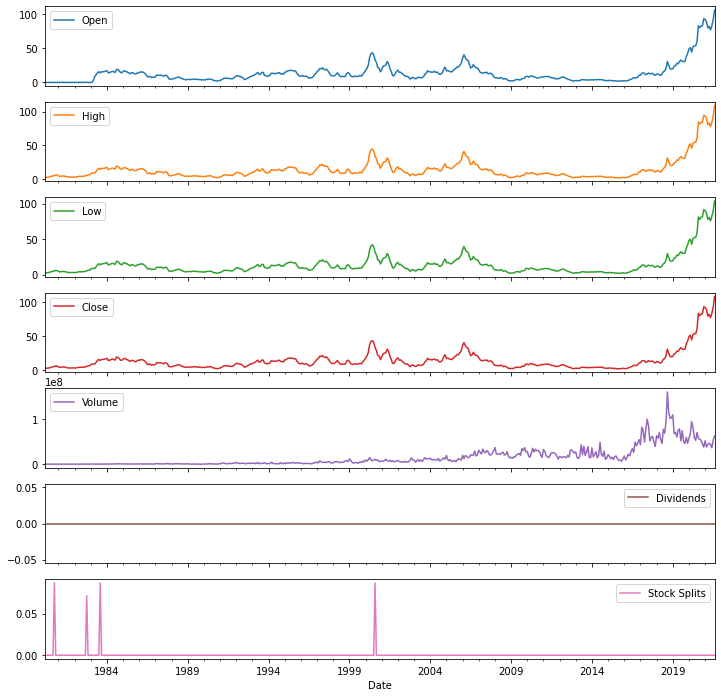

In [13]:
amd_hist.plot(kind='line', figsize=(12,12), subplots=True)